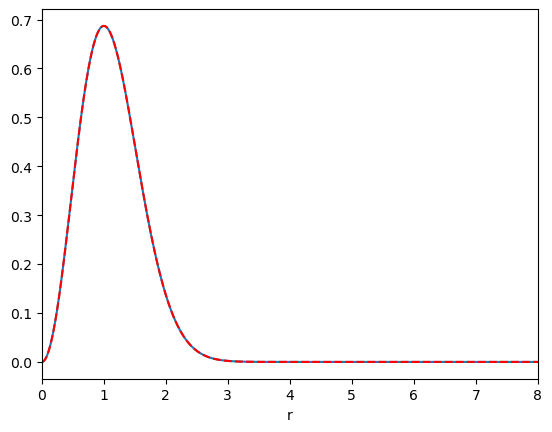

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

N = 500                                           # Truncation ordem

L0 = 15                                             # Map parameter 

col = np.cos(np.arange(2*N + 3)*math.pi /(2*N + 2))      # Collocation points w origin included (Verificado)
                               
colr = col[1:N+2]                                                                    

r1 = L0 * colr/(np.sqrt(1-colr**2))                        # Physical domain (Verificado) 
r = np.flip(r1)                                            

#out_r = open('r_30_L02.txt', 'a')
#out_r.write(' ' +' '.join(str('%.18f'%n) for n in r)+'\n')
#out_r.close()


# Base Matrix (Rational Tchebyshev Polinomials SB): 

SB = np.zeros([N+2,N+1])
rSB = np.zeros([N+2,N+1])
rrSB = np.zeros([N+2,N+1])


for i in range(N+1+1):                                    # SB[:,0] = function in origin
  SB[i,] = np.sin((2*i+1)*np.arctan(L0/r))                                                  

for i in range(N+1+1):
  rSB[i,] = -np.cos((2*i+1)*np.arctan(L0/r))*(2*i+1)*L0/(r**2*(1+L0**2/r**2)) 

for i in range(N+1+1):
  rrSB[i,] = -np.sin((2*i+1)*np.arctan(L0/r))*(2*i+1)**2*L0**2/(r**4*(1+L0**2/r**2)**2)+2*np.cos((2*i+1)*np.arctan(L0/r))*(2*i+1)*L0/(r**3*(1+L0**2/r**2))-2*np.cos((2*i+1)*np.arctan(L0/r))*(2*i+1)*L0**3/(r**5*(1+L0**2/r**2)**2)                     

# Base function:

psi = SB[0:N+1,:]        # origin included in psi[:,0]
rpsi = rSB[0:N+1,:]
rrpsi = rrSB[0:N+1,:]



# Initial conditions of Phi (Scalar field):                                    

r0 = 0


A0 =  0.93374242       # 0.9337424  -> disperse ;  # 0.93374245  . -> colapse    (Scalar field amplitude)

sigma = 1


Phi_init = A0*r**2*(np.exp(-(r-r0)**2/sigma**2) + np.exp(-(r+r0)**2/sigma**2))      # Phi initial data w origin included (Verificado)

inv_psi = np.linalg.inv(psi)
  
a0 = np.dot(Phi_init, inv_psi)  # coeficients a(0)  (Verificado)

#out_a = open('a0_30_L02.txt', 'a')
#out_a.write(' ' +' '.join(str('%.18f'%n) for n in a0)+'\n')
#out_a.close()


Phi = np.dot(a0, psi)        # approximative solution in t = 0
rPhi= np.dot(a0, rpsi)

########################### Plot: Initial Conditions of Phi

M = 3000       # plot truncation

rplot = np.linspace(0.00000000000000001,15,M)

colplot = rplot/np.sqrt(L0**2 + rplot**2)

SBplot = np.zeros([N+1,M])
rSBplot = np.zeros([N+1,M])
rrSBplot = np.zeros([N+1,M])

for i in range(N+1):
  SBplot[i,] = np.sin((2*i+1)*np.arctan(L0/rplot))

for i in range(N+1):
  rSBplot[i,] = -np.cos((2*i+1)*np.arctan(L0/rplot))*(2*i+1)*L0/(rplot**2*(1+L0**2/rplot**2)) 

for i in range(N+1):
  rrSBplot[i,] = -np.sin((2*i+1)*np.arctan(L0/rplot))*(2*i+1)**2*L0**2/(rplot**4*(1+L0**2/rplot**2)**2)+2*np.cos((2*i+1)*np.arctan(L0/rplot))*(2*i+1)*L0/(rplot**3*(1+L0**2/rplot**2))-2*np.cos((2*i+1)*np.arctan(L0/rplot))*(2*i+1)*L0**3/(rplot**5*(1+L0**2/rplot**2)**2)                     

psiplot = SBplot[0:(N+1),:] 
rpsiplot = rSBplot[0:(N+1),:]
rrpsiplot = rrSBplot[0:(N+1),:]

Phiplot_init = A0*rplot**2*(np.exp(-(rplot-r0)**2/sigma**2)+np.exp(-(rplot+r0)**2/sigma**2))     

#Phiplot_init = np.hstack((0, Phiplot_int))

Phiplot = np.dot(a0, psiplot)

plt.plot(rplot, Phiplot, rplot, Phiplot_init, "--r")   #(Verificado)
plt.xlabel('r')
plt.xlim(0,8)
plt.show()


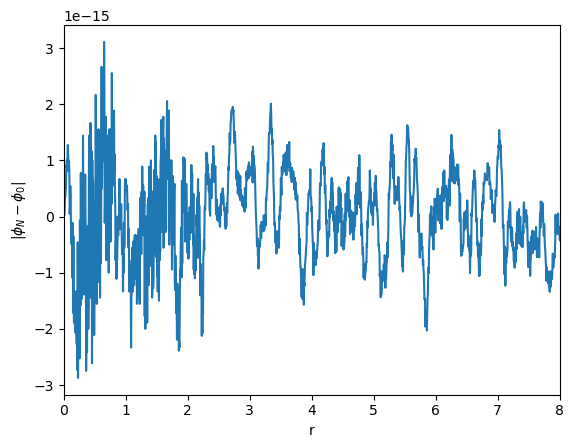

In [2]:
erro = Phiplot_init - Phiplot

plt.plot(rplot, erro)
plt.xlabel('r')
plt.xlim(0,8)
plt.ylabel("$|\phi_N - \phi_0|$")
plt.show()

In [3]:
Pi_0 = np.zeros(N+1)
b0 = np.dot(Pi_0, psi)
Pi = np.dot(b0, psi)

c0 = np.zeros([N+1])     # guess value
for i in range(N+1):
  c0[i] = 0.0001

coeforigin = 1/L0**2*(-(-1)**(np.arange(N+1))*(2*np.arange(1,N+2)-1)**2)    # 1/r * d\phi/dr

tol = 1e-19
#cnew = 0 
#err = abs(c0 - cnew)

n = 0
nf = 100

# Newton Raphson loop
#while max(err) >= tol:
while n <= nf:
  rChi = np.dot(c0 ,rpsi)
  rrChi = np.dot(c0, rrpsi)
  H0_0 = 4*rrChi[0] + 8*np.dot(coeforigin,c0) + 1/2*(rPhi[0])**2
  H0_int = 4*rChi[1:N+1]**2 + 4*rrChi[1:N+1] + 8/r[1:N+1]*rChi[1:N+1] + 1/2*rPhi[1:N+1]**2
  H0 = np.hstack((H0_0, H0_int))
  J1 = rChi*rpsi
  JH_0 = 8*J1[:,0]+ 4*rrpsi[:,0] + 8*coeforigin
  JH_int = 8*J1[:,1:N+1] + 4*rrpsi[:,1:N+1] + 8/r[1:N+1]*rpsi[:,1:N+1]  
  JH = np.column_stack((JH_0, JH_int))
  inv_JH = np.linalg.inv(JH)
  cnew = c0
  c0 = c0 - np.dot(H0, inv_JH)
  err = abs(c0 - cnew)
  print(max(err))
  if  max(err) <= tol:
    break
  n = n + 1
Chi = np.dot(c0, psi)

0.03486110565174748
0.0034177646700560213
3.6388704677536854e-06
5.274357339768443e-12
6.938893903907228e-18
2.168404344971009e-19
6.938893903907228e-18
4.336808689942018e-19
1.734723475976807e-18
6.938893903907228e-18
6.938893903907228e-18
1.734723475976807e-18
1.734723475976807e-18
1.734723475976807e-18
6.938893903907228e-18
3.469446951953614e-18
4.0657581468206416e-20


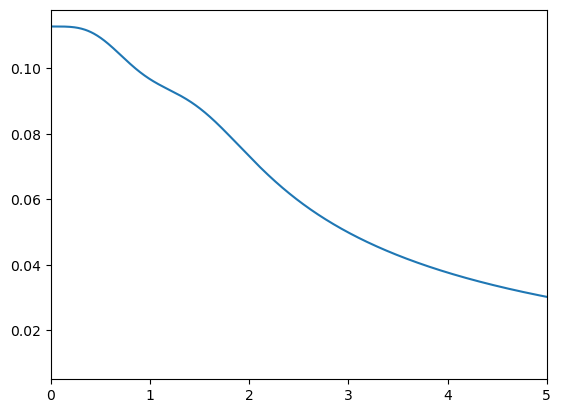

In [4]:

Chiplot = np.dot(c0, psiplot)

rrChiplot = np.dot(c0, rrpsiplot)

plt.plot(rplot,Chiplot)
plt.xlim(0,5)
plt.show()
     

In [5]:
# Equation for Krr: momentum constraint

# Initial values of Krr: Base functions of Krr

# In r = 0: 

SB1 = 1/2*(SB[1:(N+1),:] + SB[0:(N),:])          # VERIFICADO
rSB1 = 1/2*(rSB[1:(N+1),:] + rSB[0:(N),:])
rrSB1 = 1/2*(rrSB[1:(N+1),:] + rrSB[0:(N),:])

# Base functions for Beta

SB2 = np.zeros([N,N+1])      
rSB2 = np.zeros([N,N+1])
rrSB2 = np.zeros([N,N+1])



for i in range(N):                                                   # VERIFICADO
  SB2[i,] = np.sin((2*(i+1/2)+1)*np.arctan(L0/r))                                                  


for i in range(N):
  rSB2[i,] = -np.cos((2*i+2)*np.arctan(L0/r))*(2*i+2)*L0/(r**2*(1+L0**2/r**2))


for i in range(N):
  rrSB2[i,] = -np.sin((2*i+2)*np.arctan(L0/r))*(2*i+2)**2*L0**2/(r**4*(1+L0**2/r**2)**2)+2*np.cos((2*i+2)*np.arctan(L0/r))*(2*i+2)*L0/(r**3*(1+L0**2/r**2))-2*np.cos((2*i+2)*np.arctan(L0/r))*(2*i+2)*L0**3/(r**5*(1+L0**2/r**2)**2)






In [6]:
np.shape(SB2)

(500, 501)

In [7]:
np.shape(SB1)

(500, 501)

In [8]:
Nq = int(3/2*N)           # Quadrature truncation

gauss_quadrature = np.polynomial.legendre.leggauss(Nq + 1) 

new_col = gauss_quadrature[0]            # Legendre quadrature points


# Legendre Polinomials

P = np.zeros([Nq+3,Nq+1])
colP = np.zeros([Nq+3,Nq+1])

P[0,] = 1
P[1,] = new_col

colP[0,] = 0
colP[1,] = 1

for i in range(2,Nq+3):
  P[i,] = ((2*i-1)*new_col*P[i-1,] - (i-1)*P[i-2,])/(i)   

for i in range(2,Nq+3):
  colP[i,] = i*P[i-1] + new_col*colP[i-1]

P_max = P[Nq+1]

colP_max = colP[Nq+1]

wq_col = 2/((1-new_col**2)*colP_max**2)    # Legendre weight (Verificado)

rq = L0*(1+new_col)/(1-new_col)            # Physical quadrature domain

qSB = np.zeros([Nq+1,Nq+1])
qrSB = np.zeros([Nq+1,Nq+1])
qrrSB = np.zeros([Nq+1,Nq+1])


for i in range(Nq+1):
  qSB[i,] = np.sin((2*i+1)*np.arctan(L0/rq))                                                  

for i in range(Nq+1):
  qrSB[i,] = -np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0/(rq**2*+L0**2)

for i in range(Nq+1):
  qrrSB[i,] = -np.sin((2*i+1)*np.arctan(L0/rq))*(2*i+1)**2*L0**2/(rq**4*(1+L0**2/rq**2)**2)+2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0/(rq**3*(1+L0**2/rq**2))-2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0**3/(rq**5*(1+L0**2/rq**2)**2)                     

qpsi = qSB[0:N+1,:]
rqpsi = qrSB[0:N+1,:]
rrqpsi = qrrSB[0:N+1,:]


qSB1 = 1/2*(qSB[1:(N+1),:] + qSB[0:(N),:])          # VERIFICADO
rqSB1 = 1/2*(qrSB[1:(N+1),:] + qrSB[0:(N),:])
rrqSB1 = 1/2*(qSB[1:(N+1),:] + qrrSB[0:(N),:])



# Initial Phi in quadrature points

#qPhi = np.dot(a0, qpsi)      
#rqPhi= np.dot(a0, rqpsi)

# Initial Pi for quadrature points

#qPi = np.dot(b0, qpsi) 


# Initial Chi for quadrature points:

#qChi = np.dot(c0, qpsi)   # Verificado todos
#rqChi = np.dot(c0, rqpsi)
#rrqChi = np.dot(c0, rrqpsi)

# Initial values of Krr:

#qKrr = np.dot(ck0, qSB1) 

# Alpha na origem

#Alphacenter = (-1)**(np.arange(N+1))


In [9]:
Nc = 50

Nf = N - Nc

coef_f = 36
s = 20

#filter1 = np.ones(N+1)
#filter2 = np.ones(N)
filter1 = np.hstack((np.ones(Nc),np.exp(- coef_f*((np.arange(N - Nc + 1))/(N-Nc))**s)))
filter2 = np.hstack((np.ones(Nc),np.exp(- coef_f*((np.arange(N - Nc))/(N-Nc))**s)))

In [10]:
# Runge Kutta 4th order
import time

init = time.time()

h = 0.0005   # step size
tf = 10

It = int(tf/h)

#t1 = np.linspace(0, tf, It) 

t = 0

Alpha_origin = []
phi_origin = []
L2HC = []
phi_set = []

out_a = open('Alpha_origin.txt', 'a')
out_a.truncate(0)                        # arase the old datas and start the new ones

out_p = open('phi_origin.txt', 'a')
out_p.truncate(0)
V = 0

#matriz = np.concatenate((array1, array2))

while t <= tf:
   
  # First step
  Phi = np.dot(a0, psi)      
  rPhi = np.dot(a0, rpsi)
  rrPhi = np.dot(a0, rrpsi)      
  Pi = np.dot(b0, psi) 
  rPi= np.dot(b0, rpsi)
  Chi = np.dot(c0, psi) 
  rChi = np.dot(c0, rpsi)
  rrChi = np.dot(c0, rrpsi)   
  Matrix_Krr = 2*rChi[1:N+1]*SB1[:,1:N+1] + rSB1[:,1:N+1] + 3/r[1:N+1]*SB1[:,1:N+1]   # (p, p)
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi[1:N+1]*rPhi[1:N+1]*np.exp(4*Chi[1:N+1]) # (p,)
  ck0 = np.dot(rhsk, inv_matrix_krr)  # (p,)
  Krr = np.dot(ck0, SB1)              # (p+1,)     
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha_0 = rrpsi[:,0] + 2*coeforigin - np.exp(4*Chi[0])*Pi[0]**2*psi[:,0]
  Matrix_Alpha_int = rrpsi[:,1:N+1] + 2*(1/r[1:N+1] + rChi[1:N+1])*rpsi[:,1:N+1] - 3/2*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]**2*psi[:,1:N+1] - np.exp(4*Chi[1:N+1])*(Pi[1:N+1]**2 - V)*psi[:,1:N+1] 
  Matrix_Alpha = np.column_stack((Matrix_Alpha_0, Matrix_Alpha_int))
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2[:,1:N+1] - SB2[:,1:N+1]/r[1:N+1]
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha[1:N+1]*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db_origin = 2*np.exp(-4*Chi[0])*Alpha[0]*np.dot(a0, coeforigin) + np.exp(-4*Chi[0])*Alpha[0]*rrPhi[0]
  db_int = Beta[1:N+1]*rPi[1:N+1] + np.exp(-4*Chi[1:N+1])*(2*Alpha[1:N+1]/r[1:N+1] + rAlpha[1:N+1] + 2*rChi[1:N+1]*Alpha[1:N+1])*rPhi[1:N+1] + np.exp(-4*Chi[1:N+1])*Alpha[1:N+1]*rrPhi[1:N+1] - Alpha[1:N+1]* V
  db = np.dot(np.hstack((db_origin, db_int)), inv_psi)
  dc = np.dot(Beta*rChi + rBeta/2 - Alpha/2*np.exp(-4*Chi)*Krr, inv_psi)   
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K1 = h*(dc)
  L1 = h*(da)
  N1 = h*(db)
  
  # L2-error associated to the Hamiltonian constraint
  qPhi = np.dot(a0, qpsi)      
  rqPhi= np.dot(a0, rqpsi)
  qPi = np.dot(b0, qpsi) 
  qChi = np.dot(c0, qpsi)
  rqChi = np.dot(c0, rqpsi)
  rrqChi = np.dot(c0, rrqpsi) 
  qKrr = np.dot(ck0, qSB1)
  H = 4*rqChi**2 + 4*rrqChi + 8*rqChi/rq + 3/4*np.exp(-4*qChi)*qKrr**2 + np.exp(4*qChi)*(1/2*qPi**2 + np.exp(-4*qChi)/2*rqPhi**2)   # Hamiltonian constraint (HC)
  L2HC.append((1/2*np.dot(H**2,wq_col))**1/2)    # L2 error of HC 
  
  # Alpha origin
  Alpha_0 = 1 + np.dot(al0, psi[:,0])
  Alpha_origin.append(Alpha_0)                   # = Alphacenter in matlab
  out_a.write(str(Alpha_0))
  out_a.write(',\n')
  
  # Phi origin:  
  phi_0 = np.dot(a0, psi[:,0])
  phi_origin.append(phi_0)
  out_p.write(str(phi_0))
  out_p.write(',\n')
    
  # Second step
  Phi = np.dot(a0 + L1/2, psi)     
  rPhi= np.dot(a0 + L1/2 , rpsi)
  rrPhi = np.dot(a0 + L1/2, rrpsi) 
  Pi = np.dot(b0 + N1/2, psi)
  rPi= np.dot(b0 + N1/2, rpsi)
  Chi = np.dot(c0 + K1/2, psi)
  rChi = np.dot(c0 + K1/2, rpsi)
  rrChi = np.dot(c0 + K1/2, rrpsi)
  Matrix_Krr = 2*rChi[1:N+1]*SB1[:,1:N+1] + rSB1[:,1:N+1] + 3/r[1:N+1]*SB1[:,1:N+1]   # (p, p)
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi[1:N+1]*rPhi[1:N+1]*np.exp(4*Chi[1:N+1]) # (p,)
  ck0 = np.dot(rhsk, inv_matrix_krr)  # (p,)
  Krr = np.dot(ck0, SB1)              # (p+1,)     
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha_0 = rrpsi[:,0] + 2*coeforigin - np.exp(4*Chi[0])*Pi[0]**2*psi[:,0]
  Matrix_Alpha_int = rrpsi[:,1:N+1] + 2*(1/r[1:N+1] + rChi[1:N+1])*rpsi[:,1:N+1] - 3/2*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]**2*psi[:,1:N+1] - np.exp(4*Chi[1:N+1])*(Pi[1:N+1]**2 - V)*psi[:,1:N+1] 
  Matrix_Alpha = np.column_stack((Matrix_Alpha_0, Matrix_Alpha_int))
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2[:,1:N+1] - SB2[:,1:N+1]/r[1:N+1]
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha[1:N+1]*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db_origin = 2*np.exp(-4*Chi[0])*Alpha[0]*np.dot(a0, coeforigin) + np.exp(-4*Chi[0])*Alpha[0]*rrPhi[0]
  db_int = Beta[1:N+1]*rPi[1:N+1] + np.exp(-4*Chi[1:N+1])*(2*Alpha[1:N+1]/r[1:N+1] + rAlpha[1:N+1] + 2*rChi[1:N+1]*Alpha[1:N+1])*rPhi[1:N+1] + np.exp(-4*Chi[1:N+1])*Alpha[1:N+1]*rrPhi[1:N+1] - Alpha[1:N+1]* V
  db = np.dot(np.hstack((db_origin, db_int)), inv_psi)
  dc = np.dot(Beta*rChi + rBeta/2 - Alpha/2*np.exp(-4*Chi)*Krr, inv_psi)   
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K2 = h*(dc)
  L2 = h*(da)
  N2 = h*(db)

  # Third step
  Phi = np.dot(a0 + L2/2, psi)     
  rPhi = np.dot(a0 + L2/2 , rpsi)
  rrPhi = np.dot(a0 + L2/2, rrpsi) 
  Pi = np.dot(b0 + N2/2, psi)
  rPi= np.dot(b0 + N2/2, rpsi)
  Chi = np.dot(c0 + K2/2, psi)
  rChi = np.dot(c0 + K2/2, rpsi)
  rrChi = np.dot(c0 + K2/2, rrpsi)
  Matrix_Krr = 2*rChi[1:N+1]*SB1[:,1:N+1] + rSB1[:,1:N+1] + 3/r[1:N+1]*SB1[:,1:N+1]   # (p, p)
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi[1:N+1]*rPhi[1:N+1]*np.exp(4*Chi[1:N+1]) # (p,)
  ck0 = np.dot(rhsk, inv_matrix_krr)  # (p,)
  Krr = np.dot(ck0, SB1)              # (p+1,)     
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha_0 = rrpsi[:,0] + 2*coeforigin - np.exp(4*Chi[0])*Pi[0]**2*psi[:,0]
  Matrix_Alpha_int = rrpsi[:,1:N+1] + 2*(1/r[1:N+1] + rChi[1:N+1])*rpsi[:,1:N+1] - 3/2*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]**2*psi[:,1:N+1] - np.exp(4*Chi[1:N+1])*(Pi[1:N+1]**2 - V)*psi[:,1:N+1] 
  Matrix_Alpha = np.column_stack((Matrix_Alpha_0, Matrix_Alpha_int))
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2[:,1:N+1] - SB2[:,1:N+1]/r[1:N+1]
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha[1:N+1]*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db_origin = 2*np.exp(-4*Chi[0])*Alpha[0]*np.dot(a0, coeforigin) + np.exp(-4*Chi[0])*Alpha[0]*rrPhi[0]
  db_int = Beta[1:N+1]*rPi[1:N+1] + np.exp(-4*Chi[1:N+1])*(2*Alpha[1:N+1]/r[1:N+1] + rAlpha[1:N+1] + 2*rChi[1:N+1]*Alpha[1:N+1])*rPhi[1:N+1] + np.exp(-4*Chi[1:N+1])*Alpha[1:N+1]*rrPhi[1:N+1] - Alpha[1:N+1]* V
  db = np.dot(np.hstack((db_origin, db_int)), inv_psi)
  dc = np.dot(Beta*rChi + rBeta/2 - Alpha/2*np.exp(-4*Chi)*Krr, inv_psi)   
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K3 = h*(dc)
  L3 = h*(da)
  N3 = h*(db) 

  # Forth step  
  Phi = np.dot(filter1*a0 + L3, psi)     
  rPhi= np.dot(filter1*a0 + L3 , rpsi)
  rrPhi = np.dot(filter1*a0 + L3, rrpsi) 
  Pi = np.dot(filter1*b0 + N3, psi)
  rPi= np.dot(filter1*b0 + N3, rpsi)
  Chi = np.dot(filter1*c0 + K3, psi)
  rChi = np.dot(filter1*c0 + K3, rpsi)
  rrChi = np.dot(filter1*c0 + K3, rrpsi)
  Matrix_Krr = 2*rChi[1:N+1]*SB1[:,1:N+1] + rSB1[:,1:N+1] + 3/r[1:N+1]*SB1[:,1:N+1]   # (p, p)
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi[1:N+1]*rPhi[1:N+1]*np.exp(4*Chi[1:N+1]) # (p,)
  ck0 = np.dot(rhsk, inv_matrix_krr)  # (p,)
  Krr = np.dot(filter2*ck0, SB1)              # (p+1,)     
  rKrr = np.dot(filter2*ck0, rSB1)
  Matrix_Alpha_0 = rrpsi[:,0] + 2*coeforigin - np.exp(4*Chi[0])*Pi[0]**2*psi[:,0]
  Matrix_Alpha_int = rrpsi[:,1:N+1] + 2*(1/r[1:N+1] + rChi[1:N+1])*rpsi[:,1:N+1] - 3/2*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]**2*psi[:,1:N+1] - np.exp(4*Chi[1:N+1])*(Pi[1:N+1]**2 - V)*psi[:,1:N+1] 
  Matrix_Alpha = np.column_stack((Matrix_Alpha_0, Matrix_Alpha_int))
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(filter1*al0, psi)
  rAlpha = np.dot(filter1*al0, rpsi)
  rrAlpha = np.dot(filter1*al0, rrpsi)
  Matrix_Beta = rSB2[:,1:N+1] - SB2[:,1:N+1]/r[1:N+1]
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha[1:N+1]*np.exp(-4*Chi[1:N+1])*Krr[1:N+1]
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(filter2*be0, SB2)
  rBeta = np.dot(filter2*be0, rSB2)
  db_origin = 2*np.exp(-4*Chi[0])*Alpha[0]*np.dot(a0, coeforigin) + np.exp(-4*Chi[0])*Alpha[0]*rrPhi[0]
  db_int = Beta[1:N+1]*rPi[1:N+1] + np.exp(-4*Chi[1:N+1])*(2*Alpha[1:N+1]/r[1:N+1] + rAlpha[1:N+1] + 2*rChi[1:N+1]*Alpha[1:N+1])*rPhi[1:N+1] + np.exp(-4*Chi[1:N+1])*Alpha[1:N+1]*rrPhi[1:N+1] - Alpha[1:N+1]* V
  db = np.dot(np.hstack((db_origin, db_int)), inv_psi)
  dc = np.dot(Beta*rChi + rBeta/2 - Alpha/2*np.exp(-4*Chi)*Krr, inv_psi)   
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K4 = h*(dc)
  L4 = h*(da)
  N4 = h*(db)  
  
  t = t + h
  
  print(t) 
#  if t > 9:
#    h=0.0001

    
  # Evolution functions
  a0 = a0 + 1/6 * (L1 + 2*L2 + 2*L3 + L4)
  b0 = b0 + 1/6 * (N1 + 2*N2 + 2*N3 + N4)
  c0 = c0 + 1/6 * (K1 + 2*K2 + 2*K3 + K4)  
  phi_set.append(np.dot(a0, psiplot))

#  pi_set[i,:] = np.dot(b0, psiplot)
#  chi_set[i,:] = np.dot(c0, psiplot)

out_a.close()
out_p.close()   
    
fim = time.time()    

tex = (fim - init)/60

t1 = np.linspace(0, tf, len(Alpha_origin)) 

0.0005
0.001
0.0015
0.002
0.0025
0.003
0.0035
0.004
0.0045000000000000005
0.005000000000000001
0.005500000000000001
0.006000000000000002
0.006500000000000002
0.007000000000000003
0.007500000000000003
0.008000000000000004
0.008500000000000004
0.009000000000000005
0.009500000000000005
0.010000000000000005
0.010500000000000006
0.011000000000000006
0.011500000000000007
0.012000000000000007
0.012500000000000008
0.013000000000000008
0.013500000000000009
0.014000000000000009
0.01450000000000001
0.01500000000000001
0.01550000000000001
0.01600000000000001
0.01650000000000001
0.01700000000000001
0.017500000000000012
0.018000000000000013
0.018500000000000013
0.019000000000000013
0.019500000000000014
0.020000000000000014
0.020500000000000015
0.021000000000000015
0.021500000000000016
0.022000000000000016
0.022500000000000017
0.023000000000000017
0.023500000000000017
0.024000000000000018
0.02450000000000002
0.02500000000000002
0.02550000000000002
0.02600000000000002
0.02650000000000002
0.02700000000

0.20900000000000016
0.20950000000000016
0.21000000000000016
0.21050000000000016
0.21100000000000016
0.21150000000000016
0.21200000000000016
0.21250000000000016
0.21300000000000016
0.21350000000000016
0.21400000000000016
0.21450000000000016
0.21500000000000016
0.21550000000000016
0.21600000000000016
0.21650000000000016
0.21700000000000016
0.21750000000000017
0.21800000000000017
0.21850000000000017
0.21900000000000017
0.21950000000000017
0.22000000000000017
0.22050000000000017
0.22100000000000017
0.22150000000000017
0.22200000000000017
0.22250000000000017
0.22300000000000017
0.22350000000000017
0.22400000000000017
0.22450000000000017
0.22500000000000017
0.22550000000000017
0.22600000000000017
0.22650000000000017
0.22700000000000017
0.22750000000000017
0.22800000000000017
0.22850000000000018
0.22900000000000018
0.22950000000000018
0.23000000000000018
0.23050000000000018
0.23100000000000018
0.23150000000000018
0.23200000000000018
0.23250000000000018
0.23300000000000018
0.23350000000000018


0.4210000000000003
0.4215000000000003
0.4220000000000003
0.4225000000000003
0.4230000000000003
0.4235000000000003
0.4240000000000003
0.4245000000000003
0.4250000000000003
0.4255000000000003
0.4260000000000003
0.4265000000000003
0.4270000000000003
0.4275000000000003
0.4280000000000003
0.4285000000000003
0.4290000000000003
0.4295000000000003
0.4300000000000003
0.4305000000000003
0.4310000000000003
0.4315000000000003
0.43200000000000033
0.43250000000000033
0.43300000000000033
0.43350000000000033
0.43400000000000033
0.43450000000000033
0.43500000000000033
0.43550000000000033
0.43600000000000033
0.43650000000000033
0.43700000000000033
0.43750000000000033
0.43800000000000033
0.43850000000000033
0.43900000000000033
0.43950000000000033
0.44000000000000034
0.44050000000000034
0.44100000000000034
0.44150000000000034
0.44200000000000034
0.44250000000000034
0.44300000000000034
0.44350000000000034
0.44400000000000034
0.44450000000000034
0.44500000000000034
0.44550000000000034
0.44600000000000034
0.

0.6359999999999854
0.6364999999999853
0.6369999999999852
0.6374999999999852
0.6379999999999851
0.6384999999999851
0.638999999999985
0.639499999999985
0.6399999999999849
0.6404999999999849
0.6409999999999848
0.6414999999999847
0.6419999999999847
0.6424999999999846
0.6429999999999846
0.6434999999999845
0.6439999999999845
0.6444999999999844
0.6449999999999844
0.6454999999999843
0.6459999999999843
0.6464999999999842
0.6469999999999841
0.6474999999999841
0.647999999999984
0.648499999999984
0.6489999999999839
0.6494999999999839
0.6499999999999838
0.6504999999999838
0.6509999999999837
0.6514999999999836
0.6519999999999836
0.6524999999999835
0.6529999999999835
0.6534999999999834
0.6539999999999834
0.6544999999999833
0.6549999999999833
0.6554999999999832
0.6559999999999832
0.6564999999999831
0.656999999999983
0.657499999999983
0.6579999999999829
0.6584999999999829
0.6589999999999828
0.6594999999999828
0.6599999999999827
0.6604999999999827
0.6609999999999826
0.6614999999999825
0.6619999999999825

0.8529999999999615
0.8534999999999614
0.8539999999999613
0.8544999999999613
0.8549999999999612
0.8554999999999612
0.8559999999999611
0.8564999999999611
0.856999999999961
0.857499999999961
0.8579999999999609
0.8584999999999608
0.8589999999999608
0.8594999999999607
0.8599999999999607
0.8604999999999606
0.8609999999999606
0.8614999999999605
0.8619999999999605
0.8624999999999604
0.8629999999999604
0.8634999999999603
0.8639999999999602
0.8644999999999602
0.8649999999999601
0.8654999999999601
0.86599999999996
0.86649999999996
0.8669999999999599
0.8674999999999599
0.8679999999999598
0.8684999999999597
0.8689999999999597
0.8694999999999596
0.8699999999999596
0.8704999999999595
0.8709999999999595
0.8714999999999594
0.8719999999999594
0.8724999999999593
0.8729999999999593
0.8734999999999592
0.8739999999999591
0.8744999999999591
0.874999999999959
0.875499999999959
0.8759999999999589
0.8764999999999589
0.8769999999999588
0.8774999999999588
0.8779999999999587
0.8784999999999586
0.8789999999999586
0

1.0714999999999375
1.0719999999999374
1.0724999999999374
1.0729999999999373
1.0734999999999373
1.0739999999999372
1.0744999999999372
1.0749999999999371
1.075499999999937
1.075999999999937
1.076499999999937
1.076999999999937
1.0774999999999368
1.0779999999999368
1.0784999999999367
1.0789999999999367
1.0794999999999366
1.0799999999999366
1.0804999999999365
1.0809999999999365
1.0814999999999364
1.0819999999999363
1.0824999999999363
1.0829999999999362
1.0834999999999362
1.0839999999999361
1.084499999999936
1.084999999999936
1.085499999999936
1.085999999999936
1.0864999999999359
1.0869999999999358
1.0874999999999357
1.0879999999999357
1.0884999999999356
1.0889999999999356
1.0894999999999355
1.0899999999999355
1.0904999999999354
1.0909999999999354
1.0914999999999353
1.0919999999999352
1.0924999999999352
1.0929999999999351
1.093499999999935
1.093999999999935
1.094499999999935
1.094999999999935
1.0954999999999349
1.0959999999999348
1.0964999999999347
1.0969999999999347
1.0974999999999346
1.097

1.2899999999999134
1.2904999999999134
1.2909999999999133
1.2914999999999133
1.2919999999999132
1.2924999999999132
1.292999999999913
1.293499999999913
1.293999999999913
1.294499999999913
1.2949999999999129
1.2954999999999128
1.2959999999999128
1.2964999999999127
1.2969999999999127
1.2974999999999126
1.2979999999999126
1.2984999999999125
1.2989999999999124
1.2994999999999124
1.2999999999999123
1.3004999999999123
1.3009999999999122
1.3014999999999122
1.3019999999999121
1.302499999999912
1.302999999999912
1.303499999999912
1.303999999999912
1.3044999999999118
1.3049999999999118
1.3054999999999117
1.3059999999999117
1.3064999999999116
1.3069999999999116
1.3074999999999115
1.3079999999999115
1.3084999999999114
1.3089999999999113
1.3094999999999113
1.3099999999999112
1.3104999999999112
1.3109999999999111
1.311499999999911
1.311999999999911
1.312499999999911
1.312999999999911
1.3134999999999108
1.3139999999999108
1.3144999999999107
1.3149999999999107
1.3154999999999106
1.3159999999999106
1.316

1.5089999999998893
1.5094999999998893
1.5099999999998892
1.5104999999998892
1.510999999999889
1.511499999999889
1.511999999999889
1.512499999999889
1.5129999999998889
1.5134999999998888
1.5139999999998888
1.5144999999998887
1.5149999999998887
1.5154999999998886
1.5159999999998885
1.5164999999998885
1.5169999999998884
1.5174999999998884
1.5179999999998883
1.5184999999998883
1.5189999999998882
1.5194999999998882
1.519999999999888
1.520499999999888
1.520999999999888
1.521499999999888
1.5219999999998879
1.5224999999998878
1.5229999999998878
1.5234999999998877
1.5239999999998877
1.5244999999998876
1.5249999999998876
1.5254999999998875
1.5259999999998874
1.5264999999998874
1.5269999999998873
1.5274999999998873
1.5279999999998872
1.5284999999998872
1.5289999999998871
1.529499999999887
1.529999999999887
1.530499999999887
1.530999999999887
1.5314999999998868
1.5319999999998868
1.5324999999998867
1.5329999999998867
1.5334999999998866
1.5339999999998866
1.5344999999998865
1.5349999999998865
1.535

1.728999999999865
1.729499999999865
1.729999999999865
1.730499999999865
1.7309999999998649
1.7314999999998648
1.7319999999998648
1.7324999999998647
1.7329999999998646
1.7334999999998646
1.7339999999998645
1.7344999999998645
1.7349999999998644
1.7354999999998644
1.7359999999998643
1.7364999999998643
1.7369999999998642
1.7374999999998642
1.737999999999864
1.738499999999864
1.738999999999864
1.739499999999864
1.7399999999998639
1.7404999999998638
1.7409999999998638
1.7414999999998637
1.7419999999998637
1.7424999999998636
1.7429999999998635
1.7434999999998635
1.7439999999998634
1.7444999999998634
1.7449999999998633
1.7454999999998633
1.7459999999998632
1.7464999999998632
1.746999999999863
1.747499999999863
1.747999999999863
1.748499999999863
1.7489999999998629
1.7494999999998628
1.7499999999998628
1.7504999999998627
1.7509999999998627
1.7514999999998626
1.7519999999998626
1.7524999999998625
1.7529999999998624
1.7534999999998624
1.7539999999998623
1.7544999999998623
1.7549999999998622
1.755

1.9494999999998408
1.9499999999998407
1.9504999999998407
1.9509999999998406
1.9514999999998406
1.9519999999998405
1.9524999999998405
1.9529999999998404
1.9534999999998404
1.9539999999998403
1.9544999999998403
1.9549999999998402
1.9554999999998401
1.95599999999984
1.95649999999984
1.95699999999984
1.95749999999984
1.9579999999998399
1.9584999999998398
1.9589999999998398
1.9594999999998397
1.9599999999998396
1.9604999999998396
1.9609999999998395
1.9614999999998395
1.9619999999998394
1.9624999999998394
1.9629999999998393
1.9634999999998393
1.9639999999998392
1.9644999999998392
1.964999999999839
1.965499999999839
1.965999999999839
1.966499999999839
1.9669999999998389
1.9674999999998388
1.9679999999998388
1.9684999999998387
1.9689999999998387
1.9694999999998386
1.9699999999998385
1.9704999999998385
1.9709999999998384
1.9714999999998384
1.9719999999998383
1.9724999999998383
1.9729999999998382
1.9734999999998382
1.973999999999838
1.974499999999838
1.974999999999838
1.975499999999838
1.9759999

2.170499999999892
2.1709999999998923
2.1714999999998925
2.1719999999998927
2.172499999999893
2.172999999999893
2.173499999999893
2.1739999999998934
2.1744999999998935
2.1749999999998937
2.175499999999894
2.175999999999894
2.176499999999894
2.1769999999998944
2.1774999999998945
2.1779999999998947
2.178499999999895
2.178999999999895
2.179499999999895
2.1799999999998954
2.1804999999998955
2.1809999999998957
2.181499999999896
2.181999999999896
2.182499999999896
2.1829999999998964
2.1834999999998965
2.1839999999998967
2.184499999999897
2.184999999999897
2.185499999999897
2.1859999999998974
2.1864999999998975
2.1869999999998977
2.187499999999898
2.187999999999898
2.188499999999898
2.1889999999998984
2.1894999999998985
2.1899999999998987
2.190499999999899
2.190999999999899
2.191499999999899
2.1919999999998994
2.1924999999998995
2.1929999999998997
2.1934999999999
2.1939999999999
2.1944999999999
2.1949999999999004
2.1954999999999005
2.1959999999999007
2.196499999999901
2.196999999999901
2.19749

2.3934999999999667
2.393999999999967
2.394499999999967
2.394999999999967
2.3954999999999673
2.3959999999999675
2.3964999999999677
2.396999999999968
2.397499999999968
2.397999999999968
2.3984999999999683
2.3989999999999685
2.3994999999999687
2.399999999999969
2.400499999999969
2.400999999999969
2.4014999999999693
2.4019999999999695
2.4024999999999697
2.40299999999997
2.40349999999997
2.40399999999997
2.4044999999999703
2.4049999999999705
2.4054999999999707
2.405999999999971
2.406499999999971
2.406999999999971
2.4074999999999713
2.4079999999999715
2.4084999999999717
2.408999999999972
2.409499999999972
2.409999999999972
2.4104999999999723
2.4109999999999725
2.4114999999999727
2.411999999999973
2.412499999999973
2.412999999999973
2.4134999999999733
2.4139999999999735
2.4144999999999737
2.414999999999974
2.415499999999974
2.415999999999974
2.4164999999999743
2.4169999999999745
2.4174999999999747
2.417999999999975
2.418499999999975
2.418999999999975
2.4194999999999753
2.4199999999999755
2.42

2.616000000000041
2.616500000000041
2.6170000000000413
2.6175000000000415
2.6180000000000416
2.618500000000042
2.619000000000042
2.619500000000042
2.6200000000000423
2.6205000000000425
2.6210000000000426
2.621500000000043
2.622000000000043
2.622500000000043
2.6230000000000433
2.6235000000000435
2.6240000000000436
2.624500000000044
2.625000000000044
2.625500000000044
2.6260000000000443
2.6265000000000445
2.6270000000000446
2.627500000000045
2.628000000000045
2.628500000000045
2.6290000000000453
2.6295000000000455
2.6300000000000456
2.630500000000046
2.631000000000046
2.631500000000046
2.6320000000000463
2.6325000000000465
2.6330000000000466
2.633500000000047
2.634000000000047
2.634500000000047
2.6350000000000473
2.6355000000000475
2.6360000000000476
2.636500000000048
2.637000000000048
2.637500000000048
2.6380000000000483
2.6385000000000485
2.6390000000000486
2.639500000000049
2.640000000000049
2.640500000000049
2.6410000000000493
2.6415000000000495
2.6420000000000496
2.64250000000005
2.

2.8390000000001154
2.8395000000001156
2.8400000000001158
2.840500000000116
2.841000000000116
2.8415000000001163
2.8420000000001164
2.8425000000001166
2.8430000000001168
2.843500000000117
2.844000000000117
2.8445000000001173
2.8450000000001174
2.8455000000001176
2.8460000000001178
2.846500000000118
2.847000000000118
2.8475000000001183
2.8480000000001184
2.8485000000001186
2.8490000000001188
2.849500000000119
2.850000000000119
2.8505000000001193
2.8510000000001194
2.8515000000001196
2.8520000000001198
2.85250000000012
2.85300000000012
2.8535000000001203
2.8540000000001204
2.8545000000001206
2.8550000000001208
2.855500000000121
2.856000000000121
2.8565000000001213
2.8570000000001214
2.8575000000001216
2.8580000000001218
2.858500000000122
2.859000000000122
2.8595000000001223
2.8600000000001224
2.8605000000001226
2.861000000000123
2.861500000000123
2.862000000000123
2.8625000000001233
2.8630000000001234
2.8635000000001236
2.864000000000124
2.864500000000124
2.865000000000124
2.8655000000001

3.0610000000001896
3.0615000000001897
3.06200000000019
3.06250000000019
3.0630000000001902
3.0635000000001904
3.0640000000001906
3.0645000000001907
3.065000000000191
3.065500000000191
3.0660000000001912
3.0665000000001914
3.0670000000001916
3.0675000000001917
3.068000000000192
3.068500000000192
3.0690000000001922
3.0695000000001924
3.0700000000001926
3.0705000000001927
3.071000000000193
3.071500000000193
3.0720000000001932
3.0725000000001934
3.0730000000001936
3.0735000000001937
3.074000000000194
3.074500000000194
3.0750000000001942
3.0755000000001944
3.0760000000001946
3.0765000000001947
3.077000000000195
3.077500000000195
3.0780000000001952
3.0785000000001954
3.0790000000001956
3.0795000000001957
3.080000000000196
3.080500000000196
3.0810000000001962
3.0815000000001964
3.0820000000001966
3.0825000000001967
3.083000000000197
3.083500000000197
3.0840000000001973
3.0845000000001974
3.0850000000001976
3.0855000000001978
3.086000000000198
3.086500000000198
3.0870000000001983
3.08750000000

3.284000000000264
3.284500000000264
3.2850000000002644
3.2855000000002645
3.2860000000002647
3.286500000000265
3.287000000000265
3.287500000000265
3.2880000000002654
3.2885000000002655
3.2890000000002657
3.289500000000266
3.290000000000266
3.290500000000266
3.2910000000002664
3.2915000000002665
3.2920000000002667
3.292500000000267
3.293000000000267
3.293500000000267
3.2940000000002674
3.2945000000002675
3.2950000000002677
3.295500000000268
3.296000000000268
3.296500000000268
3.2970000000002684
3.2975000000002685
3.2980000000002687
3.298500000000269
3.299000000000269
3.299500000000269
3.3000000000002694
3.3005000000002696
3.3010000000002697
3.30150000000027
3.30200000000027
3.30250000000027
3.3030000000002704
3.3035000000002706
3.3040000000002707
3.304500000000271
3.305000000000271
3.305500000000271
3.3060000000002714
3.3065000000002716
3.3070000000002717
3.307500000000272
3.308000000000272
3.3085000000002722
3.3090000000002724
3.3095000000002726
3.3100000000002727
3.310500000000273
3.3

3.505500000000338
3.506000000000338
3.5065000000003383
3.5070000000003385
3.5075000000003387
3.508000000000339
3.508500000000339
3.509000000000339
3.5095000000003393
3.5100000000003395
3.5105000000003397
3.51100000000034
3.51150000000034
3.51200000000034
3.5125000000003403
3.5130000000003405
3.5135000000003407
3.514000000000341
3.514500000000341
3.515000000000341
3.5155000000003414
3.5160000000003415
3.5165000000003417
3.517000000000342
3.517500000000342
3.518000000000342
3.5185000000003424
3.5190000000003425
3.5195000000003427
3.520000000000343
3.520500000000343
3.521000000000343
3.5215000000003434
3.5220000000003435
3.5225000000003437
3.523000000000344
3.523500000000344
3.524000000000344
3.5245000000003444
3.5250000000003445
3.5255000000003447
3.526000000000345
3.526500000000345
3.527000000000345
3.5275000000003454
3.5280000000003455
3.5285000000003457
3.529000000000346
3.529500000000346
3.530000000000346
3.5305000000003464
3.5310000000003465
3.5315000000003467
3.532000000000347
3.53

3.7285000000004125
3.7290000000004127
3.729500000000413
3.730000000000413
3.730500000000413
3.7310000000004133
3.7315000000004135
3.7320000000004137
3.732500000000414
3.733000000000414
3.733500000000414
3.7340000000004143
3.7345000000004145
3.7350000000004147
3.735500000000415
3.736000000000415
3.736500000000415
3.7370000000004153
3.7375000000004155
3.7380000000004157
3.738500000000416
3.739000000000416
3.739500000000416
3.7400000000004163
3.7405000000004165
3.7410000000004167
3.741500000000417
3.742000000000417
3.742500000000417
3.7430000000004173
3.7435000000004175
3.7440000000004177
3.744500000000418
3.745000000000418
3.745500000000418
3.7460000000004183
3.7465000000004185
3.7470000000004187
3.747500000000419
3.748000000000419
3.748500000000419
3.7490000000004193
3.7495000000004195
3.7500000000004197
3.75050000000042
3.75100000000042
3.75150000000042
3.7520000000004203
3.7525000000004205
3.7530000000004207
3.753500000000421
3.754000000000421
3.754500000000421
3.7550000000004213
3.75

3.9505000000004866
3.951000000000487
3.951500000000487
3.952000000000487
3.9525000000004873
3.9530000000004875
3.9535000000004876
3.954000000000488
3.954500000000488
3.955000000000488
3.9555000000004883
3.9560000000004885
3.9565000000004886
3.957000000000489
3.957500000000489
3.958000000000489
3.9585000000004893
3.9590000000004895
3.9595000000004896
3.96000000000049
3.96050000000049
3.96100000000049
3.9615000000004903
3.9620000000004905
3.9625000000004906
3.963000000000491
3.963500000000491
3.964000000000491
3.9645000000004913
3.9650000000004915
3.9655000000004916
3.966000000000492
3.966500000000492
3.967000000000492
3.9675000000004923
3.9680000000004925
3.9685000000004926
3.969000000000493
3.969500000000493
3.970000000000493
3.9705000000004933
3.9710000000004935
3.9715000000004936
3.972000000000494
3.972500000000494
3.973000000000494
3.9735000000004943
3.9740000000004945
3.9745000000004946
3.975000000000495
3.975500000000495
3.976000000000495
3.9765000000004953
3.9770000000004955
3.97

4.178500000000404
4.1790000000004035
4.179500000000403
4.180000000000403
4.180500000000403
4.181000000000402
4.181500000000402
4.182000000000402
4.182500000000402
4.183000000000401
4.183500000000401
4.184000000000401
4.1845000000004005
4.1850000000004
4.1855000000004
4.1860000000004
4.186500000000399
4.187000000000399
4.187500000000399
4.1880000000003985
4.188500000000398
4.189000000000398
4.189500000000398
4.190000000000397
4.190500000000397
4.191000000000397
4.191500000000397
4.192000000000396
4.192500000000396
4.193000000000396
4.1935000000003955
4.194000000000395
4.194500000000395
4.195000000000395
4.195500000000394
4.196000000000394
4.196500000000394
4.1970000000003935
4.197500000000393
4.198000000000393
4.198500000000393
4.199000000000392
4.199500000000392
4.200000000000392
4.200500000000392
4.201000000000391
4.201500000000391
4.202000000000391
4.2025000000003905
4.20300000000039
4.20350000000039
4.20400000000039
4.204500000000389
4.205000000000389
4.205500000000389
4.20600000000

4.407000000000277
4.407500000000277
4.408000000000277
4.408500000000276
4.409000000000276
4.409500000000276
4.4100000000002755
4.410500000000275
4.411000000000275
4.411500000000275
4.412000000000274
4.412500000000274
4.413000000000274
4.4135000000002735
4.414000000000273
4.414500000000273
4.415000000000273
4.415500000000272
4.416000000000272
4.416500000000272
4.417000000000272
4.417500000000271
4.418000000000271
4.418500000000271
4.4190000000002705
4.41950000000027
4.42000000000027
4.42050000000027
4.421000000000269
4.421500000000269
4.422000000000269
4.4225000000002685
4.423000000000268
4.423500000000268
4.424000000000268
4.424500000000267
4.425000000000267
4.425500000000267
4.426000000000267
4.426500000000266
4.427000000000266
4.427500000000266
4.4280000000002655
4.428500000000265
4.429000000000265
4.429500000000265
4.430000000000264
4.430500000000264
4.431000000000264
4.431500000000264
4.432000000000263
4.432500000000263
4.433000000000263
4.4335000000002625
4.434000000000262
4.43450

4.635000000000151
4.6355000000001505
4.63600000000015
4.63650000000015
4.63700000000015
4.637500000000149
4.638000000000149
4.638500000000149
4.639000000000149
4.639500000000148
4.640000000000148
4.640500000000148
4.6410000000001475
4.641500000000147
4.642000000000147
4.642500000000147
4.643000000000146
4.643500000000146
4.644000000000146
4.6445000000001455
4.645000000000145
4.645500000000145
4.646000000000145
4.646500000000144
4.647000000000144
4.647500000000144
4.648000000000144
4.648500000000143
4.649000000000143
4.649500000000143
4.6500000000001425
4.650500000000142
4.651000000000142
4.651500000000142
4.652000000000141
4.652500000000141
4.653000000000141
4.6535000000001405
4.65400000000014
4.65450000000014
4.65500000000014
4.655500000000139
4.656000000000139
4.656500000000139
4.657000000000139
4.657500000000138
4.658000000000138
4.658500000000138
4.6590000000001375
4.659500000000137
4.660000000000137
4.660500000000137
4.661000000000136
4.661500000000136
4.662000000000136
4.66250000

4.864000000000024
4.864500000000024
4.865000000000023
4.865500000000023
4.866000000000023
4.8665000000000225
4.867000000000022
4.867500000000022
4.868000000000022
4.868500000000021
4.869000000000021
4.869500000000021
4.8700000000000205
4.87050000000002
4.87100000000002
4.87150000000002
4.872000000000019
4.872500000000019
4.873000000000019
4.873500000000019
4.874000000000018
4.874500000000018
4.875000000000018
4.8755000000000175
4.876000000000017
4.876500000000017
4.877000000000017
4.877500000000016
4.878000000000016
4.878500000000016
4.8790000000000155
4.879500000000015
4.880000000000015
4.880500000000015
4.881000000000014
4.881500000000014
4.882000000000014
4.882500000000014
4.883000000000013
4.883500000000013
4.884000000000013
4.8845000000000125
4.885000000000012
4.885500000000012
4.886000000000012
4.886500000000011
4.887000000000011
4.887500000000011
4.888000000000011
4.88850000000001
4.88900000000001
4.88950000000001
4.8900000000000095
4.890500000000009
4.891000000000009
4.89150000

5.093999999999896
5.094499999999896
5.094999999999896
5.095499999999896
5.095999999999895
5.096499999999895
5.096999999999895
5.0974999999998944
5.097999999999894
5.098499999999894
5.098999999999894
5.099499999999893
5.099999999999893
5.100499999999893
5.1009999999998925
5.101499999999892
5.101999999999892
5.102499999999892
5.102999999999891
5.103499999999891
5.103999999999891
5.104499999999891
5.10499999999989
5.10549999999989
5.10599999999989
5.1064999999998895
5.106999999999889
5.107499999999889
5.107999999999889
5.108499999999888
5.108999999999888
5.109499999999888
5.1099999999998875
5.110499999999887
5.110999999999887
5.111499999999887
5.111999999999886
5.112499999999886
5.112999999999886
5.113499999999886
5.113999999999885
5.114499999999885
5.114999999999885
5.1154999999998845
5.115999999999884
5.116499999999884
5.116999999999884
5.117499999999883
5.117999999999883
5.118499999999883
5.1189999999998825
5.119499999999882
5.119999999999882
5.120499999999882
5.120999999999881
5.12149

5.32249999999977
5.3229999999997695
5.323499999999769
5.323999999999769
5.324499999999769
5.324999999999768
5.325499999999768
5.325999999999768
5.3264999999997675
5.326999999999767
5.327499999999767
5.327999999999767
5.328499999999766
5.328999999999766
5.329499999999766
5.329999999999766
5.330499999999765
5.330999999999765
5.331499999999765
5.3319999999997645
5.332499999999764
5.332999999999764
5.333499999999764
5.333999999999763
5.334499999999763
5.334999999999763
5.3354999999997625
5.335999999999762
5.336499999999762
5.336999999999762
5.337499999999761
5.337999999999761
5.338499999999761
5.338999999999761
5.33949999999976
5.33999999999976
5.34049999999976
5.3409999999997595
5.341499999999759
5.341999999999759
5.342499999999759
5.342999999999758
5.343499999999758
5.343999999999758
5.3444999999997576
5.344999999999757
5.345499999999757
5.345999999999757
5.3464999999997564
5.346999999999756
5.347499999999756
5.347999999999756
5.348499999999755
5.348999999999755
5.349499999999755
5.34999

5.5519999999996426
5.552499999999642
5.552999999999642
5.553499999999642
5.5539999999996414
5.554499999999641
5.554999999999641
5.555499999999641
5.55599999999964
5.55649999999964
5.55699999999964
5.5574999999996395
5.557999999999639
5.558499999999639
5.558999999999639
5.559499999999638
5.559999999999638
5.560499999999638
5.560999999999638
5.561499999999637
5.561999999999637
5.562499999999637
5.5629999999996365
5.563499999999636
5.563999999999636
5.564499999999636
5.564999999999635
5.565499999999635
5.565999999999635
5.5664999999996345
5.566999999999634
5.567499999999634
5.567999999999634
5.568499999999633
5.568999999999633
5.569499999999633
5.569999999999633
5.570499999999632
5.570999999999632
5.571499999999632
5.5719999999996315
5.572499999999631
5.572999999999631
5.573499999999631
5.57399999999963
5.57449999999963
5.57499999999963
5.5754999999996295
5.575999999999629
5.576499999999629
5.576999999999629
5.577499999999628
5.577999999999628
5.578499999999628
5.578999999999628
5.5794999

5.780499999999516
5.780999999999516
5.781499999999515
5.781999999999515
5.782499999999515
5.7829999999995145
5.783499999999514
5.783999999999514
5.784499999999514
5.784999999999513
5.785499999999513
5.785999999999513
5.786499999999513
5.786999999999512
5.787499999999512
5.787999999999512
5.7884999999995115
5.788999999999511
5.789499999999511
5.789999999999511
5.79049999999951
5.79099999999951
5.79149999999951
5.7919999999995095
5.792499999999509
5.792999999999509
5.793499999999509
5.793999999999508
5.794499999999508
5.794999999999508
5.795499999999508
5.795999999999507
5.796499999999507
5.796999999999507
5.7974999999995065
5.797999999999506
5.798499999999506
5.798999999999506
5.799499999999505
5.799999999999505
5.800499999999505
5.8009999999995046
5.801499999999504
5.801999999999504
5.802499999999504
5.8029999999995034
5.803499999999503
5.803999999999503
5.804499999999503
5.804999999999502
5.805499999999502
5.805999999999502
5.8064999999995015
5.806999999999501
5.807499999999501
5.8079

6.009999999999389
6.010499999999388
6.010999999999388
6.011499999999388
6.011999999999388
6.012499999999387
6.012999999999387
6.013499999999387
6.0139999999993865
6.014499999999386
6.014999999999386
6.015499999999386
6.015999999999385
6.016499999999385
6.016999999999385
6.017499999999385
6.017999999999384
6.018499999999384
6.018999999999384
6.0194999999993835
6.019999999999383
6.020499999999383
6.020999999999383
6.021499999999382
6.021999999999382
6.022499999999382
6.0229999999993815
6.023499999999381
6.023999999999381
6.024499999999381
6.02499999999938
6.02549999999938
6.02599999999938
6.02649999999938
6.026999999999379
6.027499999999379
6.027999999999379
6.0284999999993785
6.028999999999378
6.029499999999378
6.029999999999378
6.030499999999377
6.030999999999377
6.031499999999377
6.0319999999993765
6.032499999999376
6.032999999999376
6.033499999999376
6.033999999999375
6.034499999999375
6.034999999999375
6.035499999999375
6.035999999999374
6.036499999999374
6.036999999999374
6.0374999

6.238999999999262
6.2394999999992615
6.239999999999261
6.240499999999261
6.240999999999261
6.24149999999926
6.24199999999926
6.24249999999926
6.24299999999926
6.243499999999259
6.243999999999259
6.244499999999259
6.2449999999992585
6.245499999999258
6.245999999999258
6.246499999999258
6.246999999999257
6.247499999999257
6.247999999999257
6.2484999999992565
6.248999999999256
6.249499999999256
6.249999999999256
6.250499999999255
6.250999999999255
6.251499999999255
6.251999999999255
6.252499999999254
6.252999999999254
6.253499999999254
6.2539999999992535
6.254499999999253
6.254999999999253
6.255499999999253
6.255999999999252
6.256499999999252
6.256999999999252
6.2574999999992515
6.257999999999251
6.258499999999251
6.258999999999251
6.25949999999925
6.25999999999925
6.26049999999925
6.26099999999925
6.261499999999249
6.261999999999249
6.262499999999249
6.2629999999992485
6.263499999999248
6.263999999999248
6.264499999999248
6.264999999999247
6.265499999999247
6.265999999999247
6.2664999999

6.466999999999135
6.467499999999135
6.467999999999135
6.468499999999135
6.468999999999134
6.469499999999134
6.469999999999134
6.4704999999991335
6.470999999999133
6.471499999999133
6.471999999999133
6.472499999999132
6.472999999999132
6.473499999999132
6.473999999999132
6.474499999999131
6.474999999999131
6.475499999999131
6.4759999999991305
6.47649999999913
6.47699999999913
6.47749999999913
6.477999999999129
6.478499999999129
6.478999999999129
6.4794999999991285
6.479999999999128
6.480499999999128
6.480999999999128
6.481499999999127
6.481999999999127
6.482499999999127
6.482999999999127
6.483499999999126
6.483999999999126
6.484499999999126
6.4849999999991255
6.485499999999125
6.485999999999125
6.486499999999125
6.486999999999124
6.487499999999124
6.487999999999124
6.4884999999991235
6.488999999999123
6.489499999999123
6.489999999999123
6.490499999999122
6.490999999999122
6.491499999999122
6.491999999999122
6.492499999999121
6.492999999999121
6.493499999999121
6.4939999999991205
6.49449

6.696499999999008
6.696999999999008
6.697499999999008
6.697999999999007
6.698499999999007
6.698999999999007
6.699499999999007
6.699999999999006
6.700499999999006
6.700999999999006
6.7014999999990055
6.701999999999005
6.702499999999005
6.702999999999005
6.703499999999004
6.703999999999004
6.704499999999004
6.7049999999990035
6.705499999999003
6.705999999999003
6.706499999999003
6.706999999999002
6.707499999999002
6.707999999999002
6.708499999999002
6.708999999999001
6.709499999999001
6.709999999999001
6.7104999999990005
6.710999999999
6.711499999999
6.711999999999
6.712499999998999
6.712999999998999
6.713499999998999
6.7139999999989985
6.714499999998998
6.714999999998998
6.715499999998998
6.715999999998997
6.716499999998997
6.716999999998997
6.717499999998997
6.717999999998996
6.718499999998996
6.718999999998996
6.7194999999989955
6.719999999998995
6.720499999998995
6.720999999998995
6.721499999998994
6.721999999998994
6.722499999998994
6.722999999998994
6.723499999998993
6.723999999998

6.925999999998881
6.926499999998881
6.9269999999988805
6.92749999999888
6.92799999999888
6.92849999999888
6.928999999998879
6.929499999998879
6.929999999998879
6.930499999998879
6.930999999998878
6.931499999998878
6.931999999998878
6.9324999999988774
6.932999999998877
6.933499999998877
6.933999999998877
6.934499999998876
6.934999999998876
6.935499999998876
6.9359999999988755
6.936499999998875
6.936999999998875
6.937499999998875
6.937999999998874
6.938499999998874
6.938999999998874
6.939499999998874
6.939999999998873
6.940499999998873
6.940999999998873
6.9414999999988725
6.941999999998872
6.942499999998872
6.942999999998872
6.943499999998871
6.943999999998871
6.944499999998871
6.9449999999988705
6.94549999999887
6.94599999999887
6.94649999999887
6.946999999998869
6.947499999998869
6.947999999998869
6.948499999998869
6.948999999998868
6.949499999998868
6.949999999998868
6.9504999999988675
6.950999999998867
6.951499999998867
6.951999999998867
6.952499999998866
6.952999999998866
6.95349999

7.153999999998755
7.154499999998754
7.154999999998754
7.155499999998754
7.155999999998754
7.156499999998753
7.156999999998753
7.157499999998753
7.1579999999987525
7.158499999998752
7.158999999998752
7.159499999998752
7.159999999998751
7.160499999998751
7.160999999998751
7.1614999999987505
7.16199999999875
7.16249999999875
7.16299999999875
7.163499999998749
7.163999999998749
7.164499999998749
7.164999999998749
7.165499999998748
7.165999999998748
7.166499999998748
7.1669999999987475
7.167499999998747
7.167999999998747
7.168499999998747
7.168999999998746
7.169499999998746
7.169999999998746
7.1704999999987455
7.170999999998745
7.171499999998745
7.171999999998745
7.172499999998744
7.172999999998744
7.173499999998744
7.173999999998744
7.174499999998743
7.174999999998743
7.175499999998743
7.1759999999987425
7.176499999998742
7.176999999998742
7.177499999998742
7.177999999998741
7.178499999998741
7.178999999998741
7.1794999999987406
7.17999999999874
7.18049999999874
7.18099999999874
7.18149999

7.381499999998629
7.381999999998628
7.382499999998628
7.382999999998628
7.3834999999986275
7.383999999998627
7.384499999998627
7.384999999998627
7.385499999998626
7.385999999998626
7.386499999998626
7.3869999999986256
7.387499999998625
7.387999999998625
7.388499999998625
7.3889999999986244
7.389499999998624
7.389999999998624
7.390499999998624
7.390999999998623
7.391499999998623
7.391999999998623
7.3924999999986225
7.392999999998622
7.393499999998622
7.393999999998622
7.394499999998621
7.394999999998621
7.395499999998621
7.395999999998621
7.39649999999862
7.39699999999862
7.39749999999862
7.3979999999986195
7.398499999998619
7.398999999998619
7.399499999998619
7.399999999998618
7.400499999998618
7.400999999998618
7.4014999999986175
7.401999999998617
7.402499999998617
7.402999999998617
7.403499999998616
7.403999999998616
7.404499999998616
7.404999999998616
7.405499999998615
7.405999999998615
7.406499999998615
7.4069999999986145
7.407499999998614
7.407999999998614
7.408499999998614
7.4089

7.6089999999985025
7.609499999998502
7.609999999998502
7.610499999998502
7.610999999998501
7.611499999998501
7.611999999998501
7.612499999998501
7.6129999999985
7.6134999999985
7.6139999999985
7.6144999999984995
7.614999999998499
7.615499999998499
7.615999999998499
7.616499999998498
7.616999999998498
7.617499999998498
7.6179999999984975
7.618499999998497
7.618999999998497
7.619499999998497
7.619999999998496
7.620499999998496
7.620999999998496
7.621499999998496
7.621999999998495
7.622499999998495
7.622999999998495
7.6234999999984945
7.623999999998494
7.624499999998494
7.624999999998494
7.625499999998493
7.625999999998493
7.626499999998493
7.6269999999984925
7.627499999998492
7.627999999998492
7.628499999998492
7.628999999998491
7.629499999998491
7.629999999998491
7.630499999998491
7.63099999999849
7.63149999999849
7.63199999999849
7.6324999999984895
7.632999999998489
7.633499999998489
7.633999999998489
7.634499999998488
7.634999999998488
7.635499999998488
7.6359999999984876
7.6364999999

7.837999999998376
7.838499999998375
7.838999999998375
7.839499999998375
7.8399999999983745
7.840499999998374
7.840999999998374
7.841499999998374
7.841999999998373
7.842499999998373
7.842999999998373
7.8434999999983726
7.843999999998372
7.844499999998372
7.844999999998372
7.845499999998371
7.845999999998371
7.846499999998371
7.846999999998371
7.84749999999837
7.84799999999837
7.84849999999837
7.8489999999983695
7.849499999998369
7.849999999998369
7.850499999998369
7.850999999998368
7.851499999998368
7.851999999998368
7.852499999998368
7.852999999998367
7.853499999998367
7.853999999998367
7.8544999999983665
7.854999999998366
7.855499999998366
7.855999999998366
7.856499999998365
7.856999999998365
7.857499999998365
7.8579999999983645
7.858499999998364
7.858999999998364
7.859499999998364
7.859999999998363
7.860499999998363
7.860999999998363
7.861499999998363
7.861999999998362
7.862499999998362
7.862999999998362
7.8634999999983615
7.863999999998361
7.864499999998361
7.864999999998361
7.86549

8.067999999998369
8.06849999999837
8.06899999999837
8.06949999999837
8.069999999998371
8.070499999998372
8.070999999998373
8.071499999998373
8.071999999998374
8.072499999998374
8.072999999998375
8.073499999998376
8.073999999998376
8.074499999998377
8.074999999998377
8.075499999998378
8.075999999998379
8.07649999999838
8.07699999999838
8.07749999999838
8.077999999998381
8.078499999998382
8.078999999998382
8.079499999998383
8.079999999998384
8.080499999998384
8.080999999998385
8.081499999998385
8.081999999998386
8.082499999998387
8.082999999998387
8.083499999998388
8.083999999998388
8.084499999998389
8.08499999999839
8.08549999999839
8.085999999998391
8.086499999998392
8.086999999998392
8.087499999998393
8.087999999998393
8.088499999998394
8.088999999998395
8.089499999998395
8.089999999998396
8.090499999998396
8.090999999998397
8.091499999998398
8.091999999998398
8.092499999998399
8.0929999999984
8.0934999999984
8.0939999999984
8.094499999998401
8.094999999998402
8.095499999998403
8.0959

8.298999999998651
8.299499999998652
8.299999999998652
8.300499999998653
8.300999999998654
8.301499999998654
8.301999999998655
8.302499999998656
8.302999999998656
8.303499999998657
8.303999999998657
8.304499999998658
8.304999999998659
8.30549999999866
8.30599999999866
8.30649999999866
8.306999999998661
8.307499999998662
8.307999999998662
8.308499999998663
8.308999999998663
8.309499999998664
8.309999999998665
8.310499999998665
8.310999999998666
8.311499999998667
8.311999999998667
8.312499999998668
8.312999999998668
8.313499999998669
8.31399999999867
8.31449999999867
8.31499999999867
8.315499999998671
8.315999999998672
8.316499999998673
8.316999999998673
8.317499999998674
8.317999999998674
8.318499999998675
8.318999999998676
8.319499999998676
8.319999999998677
8.320499999998678
8.320999999998678
8.321499999998679
8.32199999999868
8.32249999999868
8.32299999999868
8.323499999998681
8.323999999998682
8.324499999998682
8.324999999998683
8.325499999998684
8.325999999998684
8.326499999998685
8

8.530999999998935
8.531499999998935
8.531999999998936
8.532499999998937
8.532999999998937
8.533499999998938
8.533999999998938
8.534499999998939
8.53499999999894
8.53549999999894
8.53599999999894
8.536499999998941
8.536999999998942
8.537499999998943
8.537999999998943
8.538499999998944
8.538999999998945
8.539499999998945
8.539999999998946
8.540499999998946
8.540999999998947
8.541499999998948
8.541999999998948
8.542499999998949
8.54299999999895
8.54349999999895
8.54399999999895
8.544499999998951
8.544999999998952
8.545499999998952
8.545999999998953
8.546499999998954
8.546999999998954
8.547499999998955
8.547999999998956
8.548499999998956
8.548999999998957
8.549499999998957
8.549999999998958
8.550499999998959
8.55099999999896
8.55149999999896
8.55199999999896
8.552499999998961
8.552999999998962
8.553499999998962
8.553999999998963
8.554499999998963
8.554999999998964
8.555499999998965
8.555999999998965
8.556499999998966
8.556999999998967
8.557499999998967
8.557999999998968
8.558499999998968
8

8.761999999999217
8.762499999999218
8.762999999999218
8.763499999999219
8.76399999999922
8.76449999999922
8.76499999999922
8.765499999999221
8.765999999999222
8.766499999999223
8.766999999999223
8.767499999999224
8.767999999999224
8.768499999999225
8.768999999999226
8.769499999999226
8.769999999999227
8.770499999999227
8.770999999999228
8.771499999999229
8.77199999999923
8.77249999999923
8.77299999999923
8.773499999999231
8.773999999999232
8.774499999999232
8.774999999999233
8.775499999999234
8.775999999999234
8.776499999999235
8.776999999999235
8.777499999999236
8.777999999999237
8.778499999999237
8.778999999999238
8.779499999999238
8.779999999999239
8.78049999999924
8.78099999999924
8.781499999999241
8.781999999999242
8.782499999999242
8.782999999999243
8.783499999999243
8.783999999999244
8.784499999999245
8.784999999999245
8.785499999999246
8.785999999999246
8.786499999999247
8.786999999999248
8.787499999999248
8.787999999999249
8.78849999999925
8.78899999999925
8.78949999999925
8.7

8.991999999999498
8.992499999999499
8.9929999999995
8.9934999999995
8.9939999999995
8.994499999999501
8.994999999999502
8.995499999999502
8.995999999999503
8.996499999999504
8.996999999999504
8.997499999999505
8.997999999999506
8.998499999999506
8.998999999999507
8.999499999999507
8.999999999999508
9.000499999999509
9.00099999999951
9.00149999999951
9.00199999999951
9.002499999999511
9.002999999999512
9.003499999999512
9.003999999999513
9.004499999999513
9.004999999999514
9.005499999999515
9.005999999999515
9.006499999999516
9.006999999999517
9.007499999999517
9.007999999999518
9.008499999999518
9.008999999999519
9.00949999999952
9.00999999999952
9.01049999999952
9.010999999999521
9.011499999999522
9.011999999999523
9.012499999999523
9.012999999999524
9.013499999999524
9.013999999999525
9.014499999999526
9.014999999999526
9.015499999999527
9.015999999999528
9.016499999999528
9.016999999999529
9.01749999999953
9.01799999999953
9.01849999999953
9.018999999999531
9.019499999999532
9.01999

9.223999999999782
9.224499999999782
9.224999999999783
9.225499999999784
9.225999999999784
9.226499999999785
9.226999999999785
9.227499999999786
9.227999999999787
9.228499999999787
9.228999999999788
9.229499999999788
9.229999999999789
9.23049999999979
9.23099999999979
9.23149999999979
9.231999999999791
9.232499999999792
9.232999999999793
9.233499999999793
9.233999999999794
9.234499999999795
9.234999999999795
9.235499999999796
9.235999999999796
9.236499999999797
9.236999999999798
9.237499999999798
9.237999999999799
9.2384999999998
9.2389999999998
9.2394999999998
9.239999999999801
9.240499999999802
9.240999999999802
9.241499999999803
9.241999999999804
9.242499999999804
9.242999999999805
9.243499999999806
9.243999999999806
9.244499999999807
9.244999999999807
9.245499999999808
9.245999999999809
9.24649999999981
9.24699999999981
9.24749999999981
9.247999999999811
9.248499999999812
9.248999999999812
9.249499999999813
9.249999999999813
9.250499999999814
9.250999999999815
9.251499999999815
9.25

9.456000000000065
9.456500000000066
9.457000000000066
9.457500000000067
9.458000000000068
9.458500000000068
9.459000000000069
9.45950000000007
9.46000000000007
9.46050000000007
9.461000000000071
9.461500000000072
9.462000000000073
9.462500000000073
9.463000000000074
9.463500000000074
9.464000000000075
9.464500000000076
9.465000000000076
9.465500000000077
9.466000000000077
9.466500000000078
9.467000000000079
9.46750000000008
9.46800000000008
9.46850000000008
9.469000000000081
9.469500000000082
9.470000000000082
9.470500000000083
9.471000000000084
9.471500000000084
9.472000000000085
9.472500000000085
9.473000000000086
9.473500000000087
9.474000000000087
9.474500000000088
9.475000000000088
9.475500000000089
9.47600000000009
9.47650000000009
9.477000000000091
9.477500000000092
9.478000000000092
9.478500000000093
9.479000000000093
9.479500000000094
9.480000000000095
9.480500000000095
9.481000000000096
9.481500000000096
9.482000000000097
9.482500000000098
9.483000000000098
9.483500000000099


9.68850000000035
9.68900000000035
9.68950000000035
9.690000000000351
9.690500000000352
9.691000000000352
9.691500000000353
9.692000000000354
9.692500000000354
9.693000000000355
9.693500000000355
9.694000000000356
9.694500000000357
9.695000000000357
9.695500000000358
9.696000000000359
9.69650000000036
9.69700000000036
9.69750000000036
9.698000000000361
9.698500000000362
9.699000000000362
9.699500000000363
9.700000000000363
9.700500000000364
9.701000000000365
9.701500000000365
9.702000000000366
9.702500000000366
9.703000000000367
9.703500000000368
9.704000000000368
9.704500000000369
9.70500000000037
9.70550000000037
9.70600000000037
9.706500000000371
9.707000000000372
9.707500000000373
9.708000000000373
9.708500000000374
9.709000000000374
9.709500000000375
9.710000000000376
9.710500000000376
9.711000000000377
9.711500000000377
9.712000000000378
9.712500000000379
9.71300000000038
9.71350000000038
9.71400000000038
9.714500000000381
9.715000000000382
9.715500000000382
9.716000000000383
9.71

9.920000000000632
9.920500000000633
9.921000000000634
9.921500000000634
9.922000000000635
9.922500000000635
9.923000000000636
9.923500000000637
9.924000000000637
9.924500000000638
9.925000000000638
9.925500000000639
9.92600000000064
9.92650000000064
9.92700000000064
9.927500000000641
9.928000000000642
9.928500000000643
9.929000000000643
9.929500000000644
9.930000000000645
9.930500000000645
9.931000000000646
9.931500000000646
9.932000000000647
9.932500000000648
9.933000000000648
9.933500000000649
9.93400000000065
9.93450000000065
9.93500000000065
9.935500000000651
9.936000000000652
9.936500000000652
9.937000000000653
9.937500000000654
9.938000000000654
9.938500000000655
9.939000000000656
9.939500000000656
9.940000000000657
9.940500000000657
9.941000000000658
9.941500000000659
9.94200000000066
9.94250000000066
9.94300000000066
9.943500000000661
9.944000000000662
9.944500000000662
9.945000000000663
9.945500000000663
9.946000000000664
9.946500000000665
9.947000000000665
9.947500000000666
9

In [11]:
print(tex)

17.003533975283304


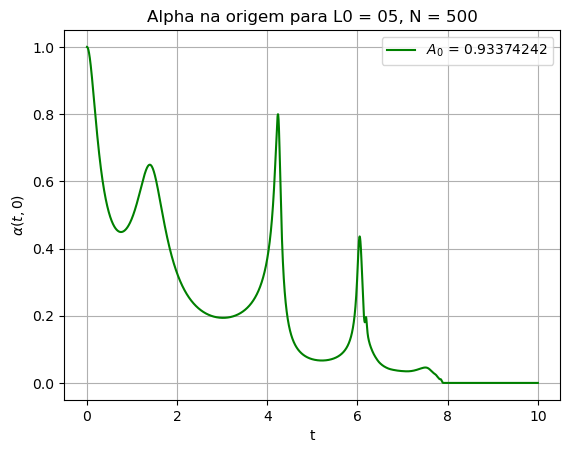

In [12]:
# Searching for critical amplitude:

plt.plot(t1, Alpha_origin, color = "g", label = "$A_0$ = {:}".format(A0))
plt.title("Alpha na origem para L0 = 05, N = {:}".format(N))
plt.ylabel(r"$\alpha(t,0)$")
plt.xlabel("t")
plt.grid()
plt.legend()

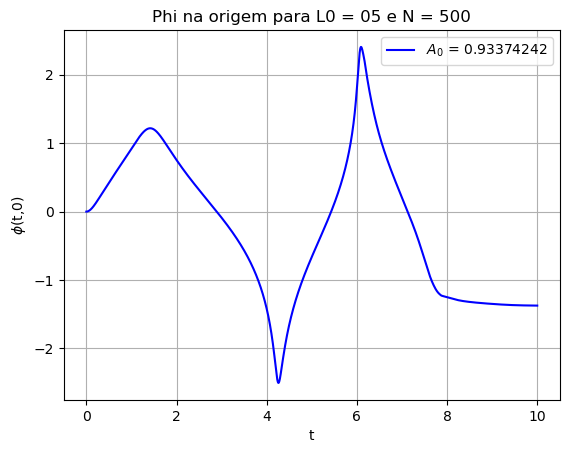

In [13]:
plt.plot(t1, phi_origin, color = "b", label = "$A_0$ = {:}".format(A0))
plt.title("Phi na origem para L0 = 05 e N = {:}".format(N) )
plt.ylabel("$\phi$(t,0)")
plt.xlabel("t")  
#plt.xlim(7.2,8.2)
plt.grid()
plt.legend() 

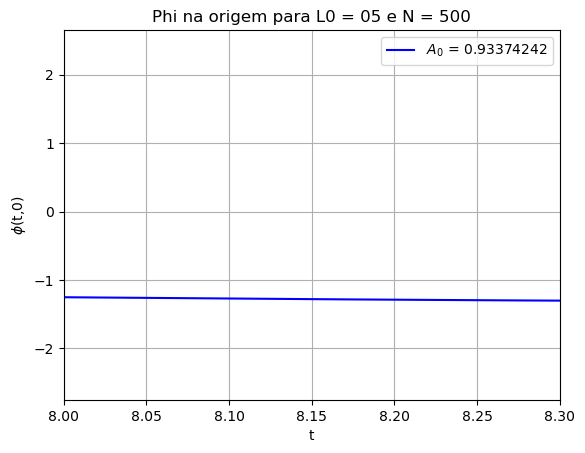

In [14]:
plt.plot(t1, phi_origin, color = "b", label = "$A_0$ = {:}".format(A0))
plt.title("Phi na origem para L0 = 05 e N = {:}".format(N) )
plt.ylabel("$\phi$(t,0)")
plt.xlabel("t")  
plt.xlim(8,8.3)
plt.grid()
plt.legend() 

In [15]:
# Erro L2 of Hamiltonian constraint

#plt.plot(t1,L2HC, label = " $A_0$ = {:}".format(A0))
#plt.yscale("log")
#plt.ylabel("log(L2HC)")
#plt.xlabel("t")
#plt.title("log(L2HC) para $N = 600$, $L_0 = 5$")
#plt.legend()

In [16]:
# 2D Animation plot for Phi: Scalar Field
        
#from matplotlib.animation import FuncAnimation
#from IPython.display import HTML

#fig = plt.figure()
#ax = plt.axes(xlim=(0, 15),ylim = (-2.2, 1.2))
#line, = ax.plot([], [], lw=2)
#initA0_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
time_text = ax.text(0.02, 0.9, '', transform=ax.transAxes)
x = rplot


def init():
    line.set_data([], [])
    initA0_text.set_text('')
    time_text.set_text('')
    return line,

def animate(i):
  y = phi_set[i]
  line.set_data(x, y)
  initA0_text.set_text("$A_0 = {:}$".format(A0))
  time_text.set_text("Time ="+str(round(h+h*i,2)))
  return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=It, interval=0.5, blit=True)

HTML(anim.to_html5_video())

NameError: name 'ax' is not defined

In [ ]:
# Plot 3D for Phi:

#from mpl_toolkits.mplot3d import Axes3D
#rplot = np.linspace(0.000001,80,M)

#fig = plt.figure(figsize=(12,6))
#ax1 = fig.add_subplot(121)
#ax2 = fig.add_subplot(122,projection='3d')

y = phi_set[0]
x = rplot
theta = np.linspace(0, 2*np.pi, M)    # Revolution of f(phi,r)

xn = np.outer(x, np.cos(theta))
yn = np.outer(x, np.sin(theta))
zn = np.zeros_like(xn)

for i in range(len(x)):
    zn[i,:] = np.full_like(zn[0], y[i])

ax1.plot(x, y)
ax2.plot_surface(xn, yn, zn)
plt.show()

In [ ]:
# 3D animation plot for Phi:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

rplot = np.linspace(0.000001,80,M)
theta = np.linspace(0, 2*np.pi, M)    # Revolution of f(phi,r)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

xn = np.outer(rplot, np.cos(theta))
yn = np.outer(rplot, np.sin(theta))
zn = np.zeros_like(xn)

def update_plot(i):
    ax1.clear()
    ax2.clear()

    y = phi_set[i]
    x = rplot

    for j in range(len(x)):
        zn[j,:] = np.full_like(zn[0], y[j])

    ax1.plot(x, y)
    ax2.plot_surface(xn, yn, zn)

ani = animation.FuncAnimation(fig, update_plot, frames=len(phi_set), interval=2)
ani.save("animation.mp4")
HTML(ani.to_html5_video())